In [1]:
# Import necessary libraries
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image


In [2]:

# Set device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda


In [3]:
# Define dataset class
class SketchDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_files = [f for f in os.listdir(root_dir) if f.endswith('.jpg') or f.endswith('.png')]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, self.image_files[idx])
        image = Image.open(img_path).convert("L")  # Convert to grayscale
        if self.transform:
            image = self.transform(image)
        return image


In [4]:

# Define image transformations
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize to 128x128
    transforms.ToTensor(),          # Convert to tensor
    transforms.Normalize((0.5,), (0.5,))  # Normalize to [-1, 1]
])

In [5]:
# Load dataset
data_dir = "/kaggle/input/cuhk-face-sketch-database-cufs/cropped_sketch"
dataset = SketchDataset(root_dir=data_dir, transform=transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)


In [6]:

# Define the VAE model
class VAE(nn.Module):
    def __init__(self, latent_dim=128):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
        )
        self.fc_mu = nn.Linear(128 * 16 * 16, latent_dim)
        self.fc_logvar = nn.Linear(128 * 16 * 16, latent_dim)
        # Decoder
        self.fc_decoder = nn.Linear(latent_dim, 128 * 16 * 16)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=4, stride=2, padding=1),
            nn.Tanh(),  # Output in range [-1, 1]
        )

    def encode(self, x):
        x = self.encoder(x)
        x = x.view(x.size(0), -1)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        x = self.fc_decoder(z)
        x = x.view(x.size(0), 128, 16, 16)
        x = self.decoder(x)
        return x

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        x_recon = self.decode(z)
        return x_recon, mu, logvar


In [7]:

# Define loss function
def vae_loss(recon_x, x, mu, logvar):
    recon_loss = nn.MSELoss()(recon_x, x)
    kld_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kld_loss / x.size(0)


In [8]:
# Initialize model, optimizer
latent_dim = 128
model = VAE(latent_dim=latent_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)


In [9]:
# Training loop
num_epochs = 50
losses = []

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for batch in tqdm(dataloader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        batch = batch.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(batch)
        loss = vae_loss(recon_batch, batch, mu, logvar)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    epoch_loss /= len(dataloader)
    losses.append(epoch_loss)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")


Epoch 1/50: 100%|██████████| 38/38 [00:03<00:00, 12.40it/s]


Epoch [1/50], Loss: 0.3651


Epoch 2/50: 100%|██████████| 38/38 [00:02<00:00, 15.59it/s]


Epoch [2/50], Loss: 0.2140


Epoch 3/50: 100%|██████████| 38/38 [00:02<00:00, 15.46it/s]


Epoch [3/50], Loss: 0.1839


Epoch 4/50: 100%|██████████| 38/38 [00:02<00:00, 16.02it/s]


Epoch [4/50], Loss: 0.1750


Epoch 5/50: 100%|██████████| 38/38 [00:02<00:00, 15.45it/s]


Epoch [5/50], Loss: 0.1695


Epoch 6/50: 100%|██████████| 38/38 [00:02<00:00, 15.83it/s]


Epoch [6/50], Loss: 0.1673


Epoch 7/50: 100%|██████████| 38/38 [00:02<00:00, 15.67it/s]


Epoch [7/50], Loss: 0.1660


Epoch 8/50: 100%|██████████| 38/38 [00:02<00:00, 15.42it/s]


Epoch [8/50], Loss: 0.1636


Epoch 9/50: 100%|██████████| 38/38 [00:02<00:00, 15.53it/s]


Epoch [9/50], Loss: 0.1633


Epoch 10/50: 100%|██████████| 38/38 [00:02<00:00, 15.50it/s]


Epoch [10/50], Loss: 0.1622


Epoch 11/50: 100%|██████████| 38/38 [00:02<00:00, 15.56it/s]


Epoch [11/50], Loss: 0.1610


Epoch 12/50: 100%|██████████| 38/38 [00:02<00:00, 15.79it/s]


Epoch [12/50], Loss: 0.1606


Epoch 13/50: 100%|██████████| 38/38 [00:02<00:00, 15.16it/s]


Epoch [13/50], Loss: 0.1603


Epoch 14/50: 100%|██████████| 38/38 [00:02<00:00, 15.35it/s]


Epoch [14/50], Loss: 0.1615


Epoch 15/50: 100%|██████████| 38/38 [00:02<00:00, 15.14it/s]


Epoch [15/50], Loss: 0.1602


Epoch 16/50: 100%|██████████| 38/38 [00:02<00:00, 15.29it/s]


Epoch [16/50], Loss: 0.1599


Epoch 17/50: 100%|██████████| 38/38 [00:02<00:00, 15.22it/s]


Epoch [17/50], Loss: 0.1600


Epoch 18/50: 100%|██████████| 38/38 [00:02<00:00, 16.11it/s]


Epoch [18/50], Loss: 0.1599


Epoch 19/50: 100%|██████████| 38/38 [00:02<00:00, 16.13it/s]


Epoch [19/50], Loss: 0.1601


Epoch 20/50: 100%|██████████| 38/38 [00:02<00:00, 16.28it/s]


Epoch [20/50], Loss: 0.1595


Epoch 21/50: 100%|██████████| 38/38 [00:02<00:00, 16.04it/s]


Epoch [21/50], Loss: 0.1596


Epoch 22/50: 100%|██████████| 38/38 [00:02<00:00, 15.90it/s]


Epoch [22/50], Loss: 0.1592


Epoch 23/50: 100%|██████████| 38/38 [00:02<00:00, 15.59it/s]


Epoch [23/50], Loss: 0.1589


Epoch 24/50: 100%|██████████| 38/38 [00:02<00:00, 15.67it/s]


Epoch [24/50], Loss: 0.1592


Epoch 25/50: 100%|██████████| 38/38 [00:02<00:00, 15.91it/s]


Epoch [25/50], Loss: 0.1591


Epoch 26/50: 100%|██████████| 38/38 [00:02<00:00, 15.60it/s]


Epoch [26/50], Loss: 0.1582


Epoch 27/50: 100%|██████████| 38/38 [00:02<00:00, 14.93it/s]


Epoch [27/50], Loss: 0.1583


Epoch 28/50: 100%|██████████| 38/38 [00:02<00:00, 16.30it/s]


Epoch [28/50], Loss: 0.1590


Epoch 29/50: 100%|██████████| 38/38 [00:02<00:00, 15.65it/s]


Epoch [29/50], Loss: 0.1588


Epoch 30/50: 100%|██████████| 38/38 [00:02<00:00, 16.61it/s]


Epoch [30/50], Loss: 0.1584


Epoch 31/50: 100%|██████████| 38/38 [00:02<00:00, 16.44it/s]


Epoch [31/50], Loss: 0.1577


Epoch 32/50: 100%|██████████| 38/38 [00:02<00:00, 16.48it/s]


Epoch [32/50], Loss: 0.1579


Epoch 33/50: 100%|██████████| 38/38 [00:02<00:00, 16.14it/s]


Epoch [33/50], Loss: 0.1579


Epoch 34/50: 100%|██████████| 38/38 [00:02<00:00, 15.66it/s]


Epoch [34/50], Loss: 0.1577


Epoch 35/50: 100%|██████████| 38/38 [00:02<00:00, 15.39it/s]


Epoch [35/50], Loss: 0.1577


Epoch 36/50: 100%|██████████| 38/38 [00:02<00:00, 15.30it/s]


Epoch [36/50], Loss: 0.1580


Epoch 37/50: 100%|██████████| 38/38 [00:02<00:00, 15.47it/s]


Epoch [37/50], Loss: 0.1585


Epoch 38/50: 100%|██████████| 38/38 [00:02<00:00, 15.27it/s]


Epoch [38/50], Loss: 0.1572


Epoch 39/50: 100%|██████████| 38/38 [00:02<00:00, 15.83it/s]


Epoch [39/50], Loss: 0.1578


Epoch 40/50: 100%|██████████| 38/38 [00:02<00:00, 15.78it/s]


Epoch [40/50], Loss: 0.1574


Epoch 41/50: 100%|██████████| 38/38 [00:02<00:00, 16.12it/s]


Epoch [41/50], Loss: 0.1580


Epoch 42/50: 100%|██████████| 38/38 [00:02<00:00, 15.58it/s]


Epoch [42/50], Loss: 0.1575


Epoch 43/50: 100%|██████████| 38/38 [00:02<00:00, 15.53it/s]


Epoch [43/50], Loss: 0.1575


Epoch 44/50: 100%|██████████| 38/38 [00:02<00:00, 15.54it/s]


Epoch [44/50], Loss: 0.1572


Epoch 45/50: 100%|██████████| 38/38 [00:02<00:00, 15.57it/s]


Epoch [45/50], Loss: 0.1574


Epoch 46/50: 100%|██████████| 38/38 [00:02<00:00, 15.69it/s]


Epoch [46/50], Loss: 0.1583


Epoch 47/50: 100%|██████████| 38/38 [00:02<00:00, 15.52it/s]


Epoch [47/50], Loss: 0.1568


Epoch 48/50: 100%|██████████| 38/38 [00:02<00:00, 15.30it/s]


Epoch [48/50], Loss: 0.1576


Epoch 49/50: 100%|██████████| 38/38 [00:02<00:00, 15.68it/s]


Epoch [49/50], Loss: 0.1570


Epoch 50/50: 100%|██████████| 38/38 [00:02<00:00, 15.66it/s]

Epoch [50/50], Loss: 0.1567


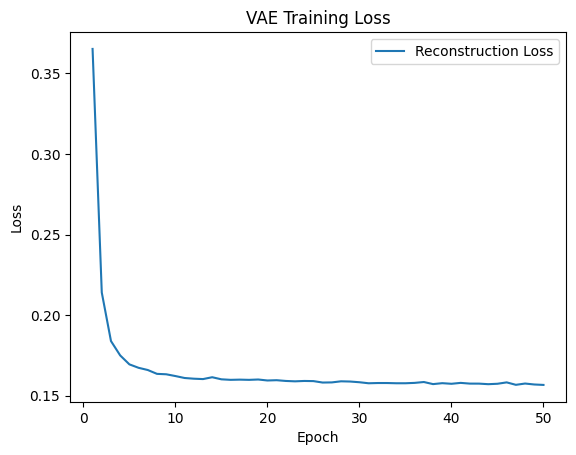

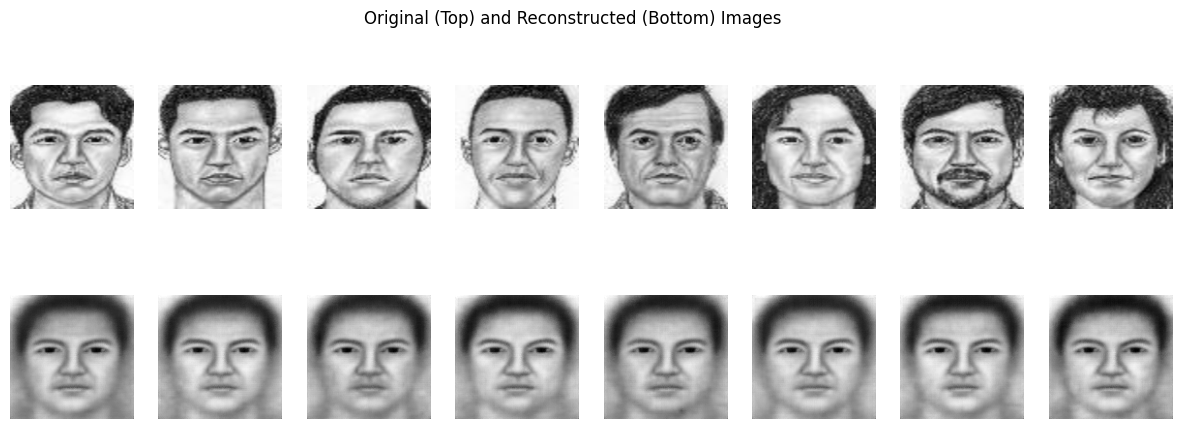

In [10]:

# Plot reconstruction loss
plt.plot(range(1, num_epochs + 1), losses, label="Reconstruction Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("VAE Training Loss")
plt.legend()
plt.show()

# Save and visualize results
model.eval()
with torch.no_grad():
    test_images = next(iter(dataloader)).to(device)
    recon_images, _, _ = model(test_images)

# Visualize original and reconstructed images
n = 8
fig, axes = plt.subplots(2, n, figsize=(15, 5))
for i in range(n):
    # Original
    axes[0, i].imshow(test_images[i].cpu().squeeze(), cmap="gray")
    axes[0, i].axis("off")
    # Reconstructed
    axes[1, i].imshow(recon_images[i].cpu().squeeze(), cmap="gray")
    axes[1, i].axis("off")
plt.suptitle("Original (Top) and Reconstructed (Bottom) Images")
plt.show()


In [11]:
torch.save(model.state_dict(), 'vae_state.pth')


In [13]:
import numpy as np
from scipy.linalg import sqrtm
from torchvision.models import inception_v3, Inception_V3_Weights
from torchvision import transforms
import torch
from torch.utils.data import DataLoader, TensorDataset

# Load InceptionV3 with updated weights API
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
weights = Inception_V3_Weights.IMAGENET1K_V1
inception = inception_v3(weights=weights).to(device)
inception.fc = torch.nn.Identity()  # Remove classification head
inception.eval()

# Image transform: Resize to 299x299 and normalize
transform = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.Normalize((0.5,), (0.5,))
])

def preprocess_images(images):
    if images.shape[1] == 1:
        images = images.repeat(1, 3, 1, 1)  # Convert grayscale to RGB
    return torch.stack([transform(img) for img in images])

def get_activations(images, model, batch_size=32, dims=2048):
    model.eval()
    dataloader = DataLoader(images, batch_size=batch_size)
    pred_arr = np.empty((len(images), dims))

    start_idx = 0
    with torch.no_grad():
        for batch in dataloader:
            batch = batch[0].to(device)
            pred = model(batch).view(batch.size(0), -1)
            pred_arr[start_idx:start_idx + batch.size(0)] = pred.cpu().numpy()
            start_idx += batch.size(0)

    return pred_arr


def calculate_fid(act1, act2):
    mu1, sigma1 = act1.mean(axis=0), np.cov(act1, rowvar=False)
    mu2, sigma2 = act2.mean(axis=0), np.cov(act2, rowvar=False)
    ssdiff = np.sum((mu1 - mu2)**2.0)
    covmean = sqrtm(sigma1.dot(sigma2))
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
    return fid

# Use your variables
real_images = test_images.to(device)
generated_images = recon_images.to(device)

real_images = preprocess_images(real_images)
generated_images = preprocess_images(generated_images)

act1 = get_activations(TensorDataset(real_images), inception)
act2 = get_activations(TensorDataset(generated_images), inception)

fid_score = calculate_fid(act1, act2)
print("FID Score:", fid_score)


FID Score: 184.3818562861621
